In [3]:
import graphlab

ImportError: No module named graphlab

In [2]:
graphlab.product_key.set_product_key('67FD-F7A7-B87B-C26C-49D3-75E6-582A-445A')

In [3]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine,correlation

import os

from subprocess import check_output

This non-commercial license of GraphLab Create for academic use is assigned to avnidas@gmail.com and will expire on December 10, 2019.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1544592582.log


In [4]:
# Read user information file:

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']

users = pd.read_csv('u.user', sep='|', names=u_cols, encoding='latin-1')

print (users.shape)

(943, 5)


In [5]:
# Read user rating file:

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings = pd.read_csv('u.data', sep='\t', names=r_cols, encoding='latin-1')

print (ratings.shape)

(100000, 4)


In [6]:
#Reading movie details file:

i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure','Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy','Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

items = pd.read_csv('u.item', sep='|', names=i_cols, encoding='latin-1')

print (items.shape)

(1682, 24)


In [7]:
#Reading movie items file:

m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']

movies = pd.read_csv('u.item', sep='|', names=m_cols, usecols=range(5),encoding='latin-1')

print (movies.shape)

(1682, 5)


In [8]:
# Reading ratings base and test

ratings_base = pd.read_csv('ua.base', sep='\t', names=r_cols, encoding='latin-1')
print (ratings_base.shape)

ratings_test = pd.read_csv('ua.test', sep='\t', names=r_cols, encoding='latin-1')
print(ratings_test.shape)

(90570, 4)
(9430, 4)


In [9]:
# create one merged DataFrame
movie_ratings = pd.merge(movies, ratings)
user_ratings = pd.merge(movie_ratings, users)

In [10]:
user_ratings.head()

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,60,M,retired,95076


# Data Pre-Processing

In [11]:
#Dropping all the columns that are not really needed

user_ratings.drop(user_ratings.columns[[3,4,7]], axis=1, inplace=True)
ratings.drop( "unix_timestamp", inplace = True, axis = 1 ) 
movies.drop(movies.columns[[3,4]], inplace = True, axis = 1 )

In [12]:
user_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
movie_id        100000 non-null int64
title           100000 non-null object
release_date    99991 non-null object
user_id         100000 non-null int64
rating          100000 non-null int64
age             100000 non-null int64
sex             100000 non-null object
occupation      100000 non-null object
zip_code        100000 non-null object
dtypes: int64(4), object(5)
memory usage: 7.6+ MB


In [13]:
most_rated = user_ratings.groupby('title').size().sort_values(ascending=False)[:10]
most_rated

title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
dtype: int64

### 3. Exploratory data analysis. ( Visualize the data, find min, max ratings etc.)

In [14]:
ratings.rating.value_counts()

4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64

,rating
4,34174
3,27145
5,21201
2,11370
1,6110


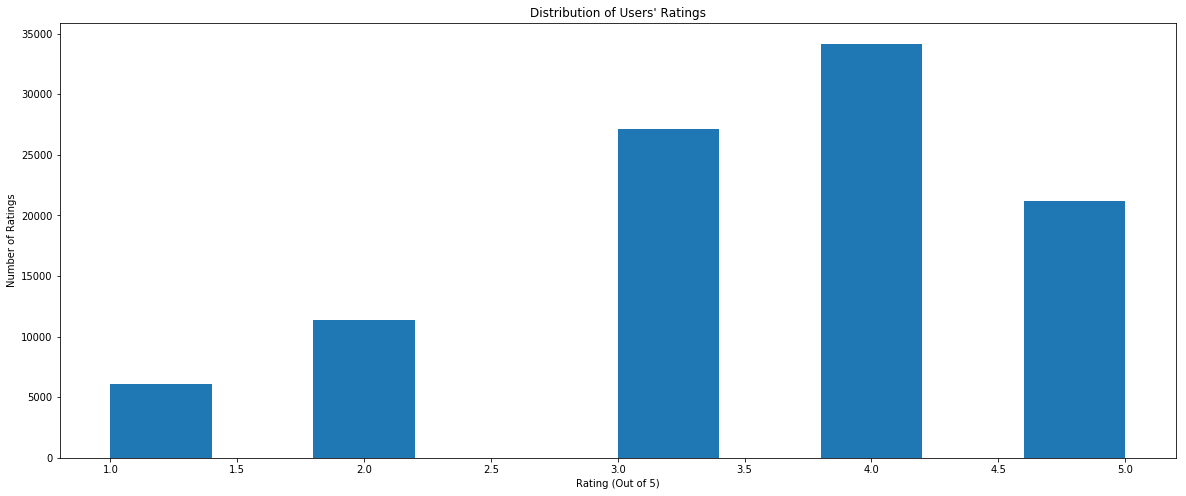

In [15]:
plt.figure(figsize=(20,8))
ratings.rating.plot.hist(bins=10, )
plt.title("Distribution of Users' Ratings")
plt.ylabel('Number of Ratings')
plt.xlabel('Rating (Out of 5)')

rating_count = pd.DataFrame(ratings.rating.value_counts())
rating_count

In [16]:
movie_stats = user_ratings.groupby('title').agg({'rating': [np.size, np.mean]})
movie_stats.head()

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000
101 Dalmatians (1996)        109  2.908257
12 Angry Men (1957)          125  4.344000
187 (1997)                    41  3.024390

In [17]:
# sort by rating average
movie_stats.sort_values([('rating', 'mean')], ascending=False).head()

rating     
                                             size mean
title                                                 
They Made Me a Criminal (1939)                  1  5.0
Marlene Dietrich: Shadow and Light (1996)       1  5.0
Saint of Fort Washington, The (1993)            2  5.0
Someone Else's America (1995)                   1  5.0
Star Kid (1997)                                 3  5.0

# Movies that have been rated at least 100 times.

In [18]:
hundred_plus_ratings = movie_stats['rating']['size'] >= 100

#sort and show the top 10 movies rated by more than a 100 users
movie_stats[hundred_plus_ratings].sort_values([('rating', 'mean')], ascending=False)[:10]

rating          
                                   size      mean
title                                            
Close Shave, A (1995)               112  4.491071
Schindler's List (1993)             298  4.466443
Wrong Trousers, The (1993)          118  4.466102
Casablanca (1942)                   243  4.456790
Shawshank Redemption, The (1994)    283  4.445230
Rear Window (1954)                  209  4.387560
Usual Suspects, The (1995)          267  4.385768
Star Wars (1977)                    583  4.358491
12 Angry Men (1957)                 125  4.344000
Citizen Kane (1941)                 198  4.292929

In [19]:
movie_stats = user_ratings.groupby('title').agg({'rating': [np.size, np.mean]})

In [20]:
most_50 = user_ratings.groupby('movie_id').size().sort_values(ascending=False)[:10]
most_50

movie_id
50     583
258    509
100    508
181    507
294    485
286    481
288    478
1      452
300    431
121    429
dtype: int64

# Users based on Age Group 

In [21]:
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
user_ratings['age_group'] = pd.cut(user_ratings.age, range(0, 81, 10), right=False, labels=labels)

user_ratings[['age', 'age_group']].drop_duplicates()[:10]

,age,age_group
0,60,60-69
397,21,20-29
459,33,30-39
524,30,30-39
782,23,20-29
995,29,20-29
1229,26,20-29
1664,31,30-39
1942,24,20-29
2270,32,30-39


### Compare ratings across age groups.

In [22]:
user_ratings.groupby('age_group').agg({'rating': [np.size, np.mean]})

rating          
            size      mean
age_group                 
0-9           43  3.767442
10-19       8181  3.486126
20-29      39535  3.467333
30-39      25696  3.554444
40-49      15021  3.591772
50-59       8704  3.635800
60-69       2623  3.648875
70-79        197  3.649746

In [23]:
user_ratings.set_index('movie_id', inplace=True)

In [24]:

by_age = user_ratings.loc[most_50.index].groupby(['title', 'age_group'])

print (by_age.rating.mean().head(15))

title                        age_group
Air Force One (1997)         10-19        3.647059
                             20-29        3.666667
                             30-39        3.570000
                             40-49        3.555556
                             50-59        3.750000
                             60-69        3.666667
                             70-79        3.666667
Contact (1997)               0-9          5.000000
                             10-19        3.693878
                             20-29        3.785714
                             30-39        3.847458
                             40-49        3.866667
                             50-59        3.739130
                             60-69        3.777778
English Patient, The (1996)  0-9          5.000000
Name: rating, dtype: float64


In [25]:
print (by_age.rating.mean().unstack(1).fillna(0)[10:20])

Empty DataFrame
Columns: [0-9, 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79]
Index: []


In [26]:
print (by_age.rating.mean().unstack(0).fillna(0))

title      Air Force One (1997)  Contact (1997)  English Patient, The (1996)  \
age_group                                                                      
0-9                    0.000000        5.000000                     5.000000   
10-19                  3.647059        3.693878                     3.739130   
20-29                  3.666667        3.785714                     3.571429   
30-39                  3.570000        3.847458                     3.621849   
40-49                  3.555556        3.866667                     3.634615   
50-59                  3.750000        3.739130                     3.774648   
60-69                  3.666667        3.777778                     3.904762   
70-79                  3.666667        0.000000                     4.500000   

title      Fargo (1996)  Independence Day (ID4) (1996)  Liar Liar (1997)  \
age_group                                                                  
0-9            0.000000                       0

DataFrame's have a pivot_table method that makes these kinds of operations much easier (and less verbose).

In [27]:
user_ratings.reset_index('movie_id', inplace=True)

In [28]:
pivoted = user_ratings.pivot_table(index=['movie_id', 'title'],columns=['sex'],values='rating',fill_value=0)
pivoted.head()

,sex,F,M
movie_id,title,,
1,Toy Story (1995),3.789916,3.909910
2,GoldenEye (1995),3.368421,3.178571
3,Four Rooms (1995),2.687500,3.108108
4,Get Shorty (1995),3.400000,3.591463
5,Copycat (1995),3.772727,3.140625


In [29]:
pivoted['diff'] = pivoted.M - pivoted.F
pivoted.head()

,sex,F,M,diff
movie_id,title,,,
1,Toy Story (1995),3.789916,3.909910,0.119994
2,GoldenEye (1995),3.368421,3.178571,-0.189850
3,Four Rooms (1995),2.687500,3.108108,0.420608
4,Get Shorty (1995),3.400000,3.591463,0.191463
5,Copycat (1995),3.772727,3.140625,-0.632102


In [30]:
pivoted.reset_index('movie_id', inplace=True)

In [31]:
import matplotlib.pyplot as plt

In [32]:
pivoted.movie_id.isin(most_50.index)

title
Toy Story (1995)                                         True
GoldenEye (1995)                                        False
Four Rooms (1995)                                       False
Get Shorty (1995)                                       False
Copycat (1995)                                          False
Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)    False
Twelve Monkeys (1995)                                   False
Babe (1995)                                             False
Dead Man Walking (1995)                                 False
Richard III (1995)                                      False
Seven (Se7en) (1995)                                    False
Usual Suspects, The (1995)                              False
Mighty Aphrodite (1995)                                 False
Postino, Il (1994)                                      False
Mr. Holland's Opus (1995)                               False
French Twist (Gazon maudit) (1995)                      False
Fr

In [33]:
print(items.shape)
items.head()

(1682, 24)


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### 6. Calculate the density of the rating matrix.

In [132]:
number_ratings=len(user_ratings)
number_movies = len(np.unique(user_ratings['movie_id']))
number_users = len(np.unique(user_ratings['user_id']))

In [137]:
density = (number_ratings*100)/((number_movies/9)*(number_users/943))

In [138]:
density

53763

### 7. Divide the data in training and testing part in the ratio 75:25.

In [37]:
from surprise import Dataset,Reader
reader = Reader(rating_scale=(1, 5))

In [38]:
data = Dataset.load_from_df(user_ratings[['user_id', 'title', 'rating']], reader)

In [70]:
# Split data to train and test
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25,random_state=123)

### 8. Apply  --
          a. Item Based Collaborative Filtering  

          b. User Based Collaborative Filtering

In [78]:
print(trainset.to_raw_uid(0))
print(trainset.to_raw_iid(1209))

488
Carrington (1995)


In [79]:
# Lets confirm the rating from the original dataset

user_ratings.loc[(user_ratings.user_id==488) & (user_ratings.title == "Carrington (1995)")]

,movie_id,title,release_date,user_id,rating,age,sex,occupation,zip_code,age_group


In [80]:
user_ratings.loc[user_ratings['title']=='Carrington (1995)']

,movie_id,title,release_date,user_id,rating,age,sex,occupation,zip_code,age_group
8551,714,Carrington (1995),01-Jan-1995,18,4,35,F,other,37212,30-39
9210,714,Carrington (1995),01-Jan-1995,271,3,51,M,engineer,22932,50-59
14507,714,Carrington (1995),01-Jan-1995,450,4,35,F,educator,11758,30-39
16425,714,Carrington (1995),01-Jan-1995,500,2,28,M,administrator,94305,20-29
39630,714,Carrington (1995),01-Jan-1995,503,4,50,F,writer,27514,50-59
55814,714,Carrington (1995),01-Jan-1995,537,3,36,M,engineer,22902,30-39
67371,714,Carrington (1995),01-Jan-1995,405,1,22,F,healthcare,10019,20-29
78921,714,Carrington (1995),01-Jan-1995,270,4,18,F,student,63119,10-19
80451,714,Carrington (1995),01-Jan-1995,409,3,48,M,administrator,98225,40-49
81949,714,Carrington (1995),01-Jan-1995,354,4,29,F,librarian,48197,20-29


# 9. Train the model.

In [81]:
from surprise import KNNWithMeans
from surprise import accuracy

In [82]:
algo = KNNWithMeans(k=10, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### 10. Evaluate the model.

In [83]:
# Evalute on test set
test_pred = algo.test(testset)

# compute RMSE
print (accuracy.rmse(test_pred))

RMSE: 0.9284
0.9283815816904908


### 11 .Recommend top - 10 movies.

In [84]:
testset_new = trainset.build_anti_testset()

In [85]:
testset_new[0:5]

[(488, u'Kids in the Hall: Brain Candy (1996)', 3.529106666666667),
 (488, u'Alien: Resurrection (1997)', 3.529106666666667),
 (488, u'Mrs. Doubtfire (1993)', 3.529106666666667),
 (488, u'French Twist (Gazon maudit) (1995)', 3.529106666666667),
 (488, u'Fan, The (1996)', 3.529106666666667)]

In [86]:
predictions = algo.test(testset_new[0:10000])

In [87]:
predictions[0:10]

[Prediction(uid=488, iid=u'Kids in the Hall: Brain Candy (1996)', r_ui=3.529106666666667, est=2.29960975574948, details={u'actual_k': 10, u'was_impossible': False}),
 Prediction(uid=488, iid=u'Alien: Resurrection (1997)', r_ui=3.529106666666667, est=2.888095396998776, details={u'actual_k': 10, u'was_impossible': False}),
 Prediction(uid=488, iid=u'Mrs. Doubtfire (1993)', r_ui=3.529106666666667, est=2.8394994178782005, details={u'actual_k': 10, u'was_impossible': False}),
 Prediction(uid=488, iid=u'French Twist (Gazon maudit) (1995)', r_ui=3.529106666666667, est=2.706782777697024, details={u'actual_k': 10, u'was_impossible': False}),
 Prediction(uid=488, iid=u'Fan, The (1996)', r_ui=3.529106666666667, est=2.7205287954247805, details={u'actual_k': 10, u'was_impossible': False}),
 Prediction(uid=488, iid=u'Two if by Sea (1996)', r_ui=3.529106666666667, est=2.0325985873381542, details={u'actual_k': 10, u'was_impossible': False}),
 Prediction(uid=488, iid=u'Shadow, The (1994)', r_ui=3.52910

In [88]:
predictions_df = pd.DataFrame([[x.uid,x.est,x.iid] for x in predictions])

In [89]:
predictions_df.columns = ["user_id","rating","iid"]
predictions_df.sort_values(by = ["user_id", "rating","iid"],ascending=False,inplace=True)

In [90]:
predictions_df.rename(columns={'iid':'Movie Name'},inplace=True)

In [91]:
predictions_df.head()

,user_id,rating,Movie Name
9830,894,5.000000,They Made Me a Criminal (1939)
9975,894,5.000000,Pather Panchali (1955)
9928,894,4.888152,Prefontaine (1997)
9433,894,4.869460,"Saint of Fort Washington, The (1993)"
9969,894,4.850253,Star Kid (1997)


In [92]:
top_10_recos = predictions_df.groupby("user_id").head(10).reset_index(drop=True)

In [95]:
top_10_recos.head()

,user_id,rating,Movie Name
0,894,5.000000,They Made Me a Criminal (1939)
1,894,5.000000,Pather Panchali (1955)
2,894,4.888152,Prefontaine (1997)
3,894,4.869460,"Saint of Fort Washington, The (1993)"
4,894,4.850253,Star Kid (1997)


# SVD Based Recommendation
 

In [96]:
# Exclude movies with very few ratings, say less than 10

movie_count = user_ratings["title"].value_counts(ascending=False)
pop_movie = movie_count.loc[movie_count.values > 10].index
len(pop_movie)

1111

In [97]:
ratings_movie = user_ratings.loc[user_ratings.title.isin(pop_movie)]
ratings_movie.shape

(97632, 10)

In [98]:
from surprise import SVD
from surprise import accuracy

In [99]:
svd_model = SVD(n_factors=50,biased = False)
svd_model.fit(trainset)

In [100]:
test_pred = svd_model.test(testset)

In [101]:
accuracy.rmse(test_pred)

RMSE: 0.9401


0.9400569972848906

In [102]:
user_factors = svd_model.pu
print (user_factors.shape)

(1623, 50)

In [106]:
item_factors = svd_model.qi
print (item_factors.shape)

(1623, 50)


In [108]:
transpose = np.transpose(item_factors)
print (transpose.shape)

(50, 1623)


In [109]:
# common features to be made part of dot product , so transpose

pred = np.dot(user_factors,np.transpose(item_factors))

In [110]:
ratings_matrix = ratings.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_matrix.fillna(0, inplace=True)
ratings_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
0,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
1,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate Cosine Similarity for rating and movie

In [111]:
movie_similarity = 1 - pairwise_distances(ratings_matrix.as_matrix(), metric="cosine")

np.fill_diagonal(movie_similarity, 0)

ratings_matrix = pd.DataFrame(movie_similarity)

ratings_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,0.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,...,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
1,0.402382,0.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
2,0.330245,0.273069,0.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,...,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
3,0.454938,0.502571,0.324866,0.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,...,0.000000,0.0,0.094022,0.094022,0.037609,0.0,0.0,0.0,0.056413,0.075218
4,0.286714,0.318836,0.212957,0.334239,0.000000,0.037299,0.334769,0.259161,0.272448,0.055453,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094211


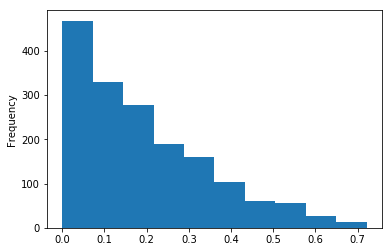

In [112]:
# Recommendation System of movies
try:
    user_inp = "Speed (1994)"
    inp = movies[movies['title']==user_inp].index.tolist()
    inp = inp[0]

    movies['similarity'] = ratings_matrix.iloc[inp]
    movies.columns = ['movie_id', 'title', 'release_date','similarity']
    movies.head(10)
    movies['similarity'].plot(kind = "hist")
except: 
    print("Sorry, the movie is not in the database!")

In [118]:
print("Recommended movies based on user profile",user_inp ,": \n", movies.sort_values( ["similarity"], ascending = False )[1:10])

('Recommended movies based on user profile', 'Speed (1994)', ': \n',      movie_id                                      title release_date  \
384       385                           True Lies (1994)  01-Jan-1994   
160       161                             Top Gun (1986)  01-Jan-1986   
78         79                       Fugitive, The (1993)  01-Jan-1993   
95         96          Terminator 2: Judgment Day (1991)  01-Jan-1991   
194       195                     Terminator, The (1984)  01-Jan-1984   
173       174             Raiders of the Lost Ark (1981)  01-Jan-1981   
209       210  Indiana Jones and the Last Crusade (1989)  01-Jan-1989   
549       550          Die Hard: With a Vengeance (1995)  01-Jan-1995   
203       204                  Back to the Future (1985)  01-Jan-1985   

     similarity  
384    0.719504  
160    0.707567  
78     0.696583  
95     0.695556  
194    0.676778  
173    0.676664  
209    0.674811  
549    0.674143  
203    0.665776  )


# Recommendation using Graph Lab

In [119]:
import graphlab
train_data = graphlab.SFrame(ratings_base)
test_data = graphlab.SFrame(ratings_test)

Simple Popularity Model
Lets start with making a popularity based model, i.e. the one where all the users have same recommendation based on the most popular choices. We’ll use the  graphlab recommender functions popularity_recommender for this.

In [120]:
popularity_model = graphlab.popularity_recommender.create(train_data, user_id='user_id', item_id='movie_id', target='rating')

Recsys training: model = popularity

Warning: Ignoring columns unix_timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 90570 observations with 943 users and 1680 items.

Data prepared in: 0.098921s

90570 observations to process; with 1680 unique items.

In [ ]:
# Show recommendations for first 10 users and print them

In [122]:
#users = range(1,11) specifies user ID of first 10 users
#k=5 specifies top 5 recommendations to be given
popularity_recomm = popularity_model.recommend(users=range(1,11),k=5)

popularity_recomm.print_rows(num_rows=50)

+---------+----------+-------+------+
| user_id | movie_id | score | rank |
+---------+----------+-------+------+
|    1    |   1500   |  5.0  |  1   |
|    1    |   1201   |  5.0  |  2   |
|    1    |   1189   |  5.0  |  3   |
|    1    |   1122   |  5.0  |  4   |
|    1    |   814    |  5.0  |  5   |
|    2    |   1500   |  5.0  |  1   |
|    2    |   1201   |  5.0  |  2   |
|    2    |   1189   |  5.0  |  3   |
|    2    |   1122   |  5.0  |  4   |
|    2    |   814    |  5.0  |  5   |
|    3    |   1500   |  5.0  |  1   |
|    3    |   1201   |  5.0  |  2   |
|    3    |   1189   |  5.0  |  3   |
|    3    |   1122   |  5.0  |  4   |
|    3    |   814    |  5.0  |  5   |
|    4    |   1500   |  5.0  |  1   |
|    4    |   1201   |  5.0  |  2   |
|    4    |   1189   |  5.0  |  3   |
|    4    |   1122   |  5.0  |  4   |
|    4    |   814    |  5.0  |  5   |
|    5    |   1500   |  5.0  |  1   |
|    5    |   1201   |  5.0  |  2   |
|    5    |   1189   |  5.0  |  3   |
|    5    | 

In [123]:
ratings_base.groupby(by='movie_id')['rating'].mean().sort_values(ascending=False).head(20)

movie_id
1500    5.000000
1293    5.000000
1122    5.000000
1189    5.000000
1656    5.000000
1201    5.000000
1599    5.000000
814     5.000000
1467    5.000000
1536    5.000000
1449    4.714286
1642    4.500000
1463    4.500000
1594    4.500000
1398    4.500000
114     4.491525
408     4.480769
169     4.476636
318     4.475836
483     4.459821
Name: rating, dtype: float64

In [126]:
#Train Model
item_sim_model = graphlab.item_similarity_recommender.create(train_data, user_id='user_id', item_id='movie_id', target='rating', similarity_type='pearson')

#Make Recommendations:
item_sim_recomm = item_sim_model.recommend(users=range(1,11),k=5)
item_sim_recomm.print_rows(num_rows=50)

Recsys training: model = item_similarity

Warning: Ignoring columns unix_timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 90570 observations with 943 users and 1680 items.

Data prepared in: 0.110942s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.349ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 6.63ms                              | 0.25             | 6               |

| 328.115ms                           | 100              | 1680            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.348953s

+---------+----------+-------+------+
| user_id | movie_id | score | rank |
+---------+----------+-------+------+
|    1    |   1293   |  5.0  |  1   |
|    1    |   1201   |  5.0  |  2   |
|    1    |   1189   |  5.0  |  3   |
|    1    |   1122   |  5.0  |  4   |
|    1    |   814    |  5.0  |  5   |
|    2    |   1293   |  5.0  |  1   |
|    2    |   1201   |  5.0  |  2   |
|    2    |   1189   |  5.0  |  3   |
|    2    |   1122   |  5.0  |  4   |
|    2    |   814    |  5.0  |  5   |
|    3    |   1293   |  5.0  |  1   |
|    3    |   1201   |  5.0  |  2   |
|    3    |   1189   |  5.0  |  3   |
|    3    |   1122   |  5.0  |  4   |
|    3    |   814    |  5.0  |  5   |
|    4    |   1293   |  5.0  |  1   |
|    4    |   1201   |  5.0  |  2   |
|    4    |   1189   |  5.0  |  3   |
|    4    |   1122   |  5.0  |  4   |
|    4    |   814    |  5.0  |  5   |
|    5    |   1293   |  5.0  |  1   |
|    5    |   1201   |  5.0  |  2   |
|    5    |   1189   |  5.0  |  3   |
|    5    | 